# Lyft: Complete train and prediction pipeline

This notebook is modified slightly from https://www.kaggle.com/huanvo/lyft-complete-train-and-prediction-pipeline


Change log:
- v12 (2020-10-29): faster prediction - reduce batch size due to machine limit on Kaggle
- v10 (2020-10-29): faster prediction
- v9 (2020-10-28): get some real training
- v8 (2020-10-25): skip computing loss to see if prediction will be faster.

# Environment setup

 - Please add [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) as utility script.
    - Official utility script "[philculliton/kaggle-l5kit](https://www.kaggle.com/mathurinache/kaggle-l5kit)" does not work with pytorch GPU.

Click "File" botton on top-left, and choose "Add utility script". For the pop-up search window, you need to remove "Your Work" filter, and search [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) on top-right of the search window. Then you can add the kaggle-l5kit utility script. It is much faster to do this rather than !pip install l5kit every time you run the notebook. 

If successful, you can see "usr/lib/lyft-l5kit-unofficial-fix" is added to the "Data" section of this kernel page on right side of the kernel.

- Also please add [pretrained baseline model](https://www.kaggle.com/huanvo/lyft-pretrained-model-hv)

Click on the button "Add data" in the "Data" section and search for lyft-pretrained-model-hv. If you find the model useful, please upvote it as well.  

In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
from tqdm import tqdm_notebook
import gc, psutil

print(l5kit.__version__)

1.1.0


In [2]:
# Memory measurement
def memory(verbose=True):
    mem = psutil.virtual_memory()
    gb = 1024*1024*1024
    if verbose:
        print('Physical memory:',
              '%.2f GB (used),'%((mem.total - mem.available) / gb),
              '%.2f GB (available)'%((mem.available) / gb), '/',
              '%.2f GB'%(mem.total / gb))
    return (mem.total - mem.available) / gb

def gc_memory(verbose=True):
    m = gc.collect()
    if verbose:
        print('GC:', m, end=' | ')
        memory()

memory();

Physical memory: 1.14 GB (used), 14.50 GB (available) / 15.64 GB


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

# Configs

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

In [5]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "../input/lyft-motion-prediction-autonomous-vehicles/",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'model_name': 'mymodel34',
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'lr': 7e-4,
        'train': True,
        'predict': True,
        'oldmodel_exists' : False,
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.25,0.25],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
    
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'train_start_index' : 58000,
        'max_num_steps': 500,
        'checkpoint_every_n_steps': 100,
    }
}

def find_no_of_trainable_params(model):
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #print(total_trainable_params)
    return total_trainable_params

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

NUMBER_OF_HISTORY_FRAMES = cfg['model_params']['history_num_frames'] + 1
RASTER_IMG_SIZE = cfg['raster_params']['raster_size'][0]
NUM_MODES = 3
NUMBER_OF_FUTURE_FRAMES = cfg['model_params']['future_num_frames']
TRAIN_BATCH_SIZE = cfg['train_data_loader']['batch_size'] 
### TRAIN FROM WHERE LEFT OFF, CHANGE THE STARTING INDICES VARIABLE ACCORDINGLY
TRAIN_START_INDICES = cfg['train_params']['train_start_index']
EXTENT_RANGE = 5.0 

# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)

sampled_indices = np.random.choice(len(train_dataset), size = len(train_dataset), replace = False)
print('Before slicing, start indices are ', sampled_indices[0:10])

TRAIN_START_INDICES

sampled_indices = sampled_indices[TRAIN_START_INDICES:TRAIN_START_INDICES+cfg['train_params']['max_num_steps']+1]
print('After slicing, start indices are ', sampled_indices[0:10])
Datasampler = SubsetRandomSampler(sampled_indices)

train_dataloader = DataLoader(train_dataset, sampler=Datasampler, batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])

Before slicing, start indices are  [ 4544818 11783688  2821987 10532781  1993967 15711361  7726097   547516
 17556178  7275034]
After slicing, start indices are  [16360233  9884923  1805097 16051402 13187266  1826901  8752735  7856572
  6518566  9451303]


Couple of things to note:

 - **model_architecture:** you can put 'resnet18', 'resnet34' or 'resnet50'. For the pretrained model we use resnet18 so we need to use 'resnet18' in the config.
 - **weight_path:** path to the pretrained model. If you don't have a pretrained model and want to train from scratch, put **weight_path** = False. 
 - **model_name:** the name of the model that will be saved as output, this is only when **train**= True.
 - **train:** True if you want to train the model.
 - **predict:** True if you want to predict and submit to Kaggle.
 - **lr:** learning rate of the model.
 - **raster_size:** specify the size of the image, the default is [224,224]. Increase **raster_size** can improve the score. However the training time will be significantly longer. 
 - **batch_size:** number of samples for one forward pass
 - **steps:** number of batches of data that the model will be trained on. (note this is not epoch)
 - **checkpoint_every_n_steps:** the model will be saved at every n steps, again change this number as to how you want to keep track of the model.
 
 
 Note (Louis): The original pretrained model doesn't save the state of optimizer, so continute training doesn't work too well.

# Load the train and test datasets

In [6]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager()

In [7]:
%%time
# Test dataset
test_cfg = cfg["test_data_loader"]
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open(cached=False)  # to prevent run out of memory
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset, shuffle=test_cfg["shuffle"],
                             batch_size=test_cfg["batch_size"], num_workers=test_cfg["num_workers"])

CPU times: user 242 ms, sys: 115 ms, total: 357 ms
Wall time: 2.9 s


In [8]:
print(len(train_dataset), len(test_dataset))

22496709 71122


Note that the train set size is much bigger than our steps * batch_size. So we will not even finish 1 epoch of training here.

# Simple visualization

Let us visualize how an input to the model looks like.

In [9]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, radius=1, yaws=data["target_yaws"])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

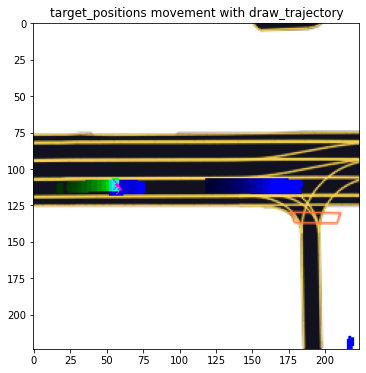

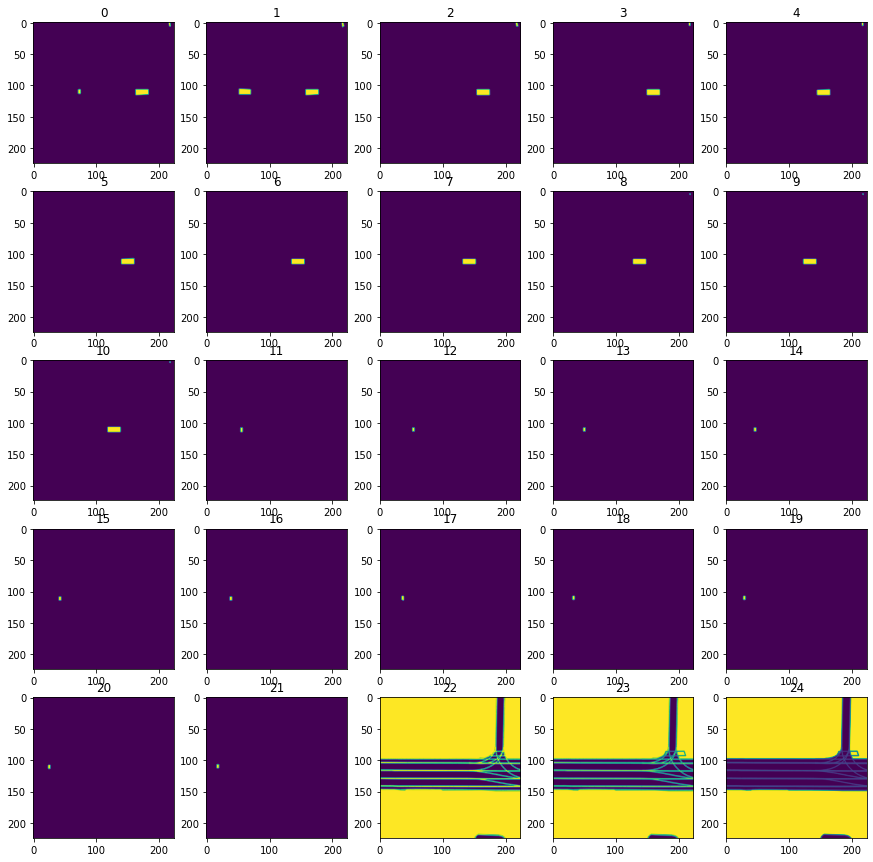

In [10]:
i_plot = 4

plt.figure(figsize=(8, 6))
visualize_trajectory(train_dataset, index=i_plot)

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1).set_title(f'{i}')
    plt.imshow(train_dataset[i_plot]['image'][i])
plt.show()

# Loss function

For this competition it is important to use the correct loss function when train the model. Our goal is to predict three possible paths together with the confidence score, so we need to use the loss function that takes that into account, simply using RMSE will not lead to an accurate model. More information about the loss function can be found here [negative log likelihood](https://github.com/lyft/l5kit/blob/master/competition.md).

In [11]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

# Model
Next we define the baseline model. Note that this model will return three possible trajectories together with confidence score for each trajectory.

In [12]:
from torchvision.models.resnet import resnet50, resnet101, resnet34

class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        self.dropout = nn.Dropout(p=0.3)
            
        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len
        other_agent_features = num_history_channels + 3 # extent info is 3d 
        total_num_features = backbone_out_features + other_agent_features
        self.head = nn.Linear(in_features=total_num_features, out_features=1024)

        # final prediction - a fc layer with desired number of outputs, no activation
        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes
        self.logit = nn.Linear(1024, out_features=self.num_preds + num_modes)

    def forward(self, x, agent_data):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # adding other agent data to image data
        x = torch.cat((x, agent_data), dim=1)

        # fc with relu activation and dropout
        x = self.dropout(F.relu(self.head(x)))
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

Add `compute_loss` flag to skip computing loss during prediction.

In [13]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    bs = inputs.shape[0]
    history_positions = data['history_positions'].to(device).view(bs, -1)
    # centroid = data['centroid'].to(device).float()
    # yaw = data['yaw'].to(device).view(TRAIN_BATCH_SIZE, 1).float()
    # agent_data = torch.cat((history_positions, centroid, yaw, extent), dim=1)
    extent = data['extent'].to(device) / EXTENT_RANGE
    agent_data = torch.cat((history_positions, extent), dim=1)
    
    # Forward pass
    preds, confidences = model(inputs, agent_data)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device {device}')



device cuda:0


Now let us initialize the model and load the pretrained weights. Note that since the pretrained model was trained on GPU, you also need to enable GPU when running this notebook.

In [14]:
%%time
# ==== INIT MODEL=================

red_factor = 0.8
patience_steps = 1000 
patience_threshold = 0.1 
smoothing = 0.02
model = LyftMultiModel(cfg)


if not cfg["model_params"]["oldmodel_exists"]:
    model.to(device)
else:
    model.to(device)
    model.load_state_dict(torch.load("../input/old-model/model_old.pth"))
    print('previous model loaded')
    model.eval()
    
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=red_factor, 
                                                patience=patience_steps, threshold= patience_threshold,
                                                verbose= True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



CPU times: user 2.46 s, sys: 1.4 s, total: 3.86 s
Wall time: 12.7 s


In [15]:
print(model)

LyftMultiModel(
  (backbone): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

# Training loop
Next let us implement the training loop, when the **train** parameter is set to True. 

In [16]:
print('TRAINING ABOUT TO START ... FROM ', TRAIN_START_INDICES, 
      '  BATCH AND FOR ', cfg['train_params']['max_num_steps'], ' BATCHES', ' WITH BATCH SIZE', TRAIN_BATCH_SIZE)

# ==== TRAINING LOOP =========================================================
if cfg["model_params"]["train"]:
    
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(TRAIN_START_INDICES, 
                              TRAIN_START_INDICES + cfg["train_params"]["max_num_steps"]))
    num_iter = cfg["train_params"]["max_num_steps"]
    losses_train = []
    smooth_losses = []
    lr_list = []
    iterations = []
    metrics = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    start = time.time()
    iteration = 0
    
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        
        # Forward pass
        model.train()
        torch.set_grad_enabled(True)
        loss, _, _ = forward(data, model, device)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_train.append(loss.item())

        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        if i % cfg['train_params']['checkpoint_every_n_steps'] == 0:
            sample_number = i * cfg['train_data_loader']['batch_size']            
            state = {
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler' : scheduler
            }
            torch.save(state, f'{model_name}_{sample_number}k.pth')
            iterations.append(i)
            metrics.append(np.mean(losses_train))
            times.append((time.time()-start)/60)
            
        # smooth the loss
        if i== TRAIN_START_INDICES:
            smooth_losses.append(loss.item())
        else:
            smooth_losses.append(smoothing  * loss.item() + (1 - smoothing) * smooth_losses[-1])
    
        scheduler.step(smooth_losses[-1])
        lr_list.append(optimizer.state_dict()["param_groups"][0]["lr"])

    sample_number = i * cfg['train_data_loader']['batch_size']
    results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
    print(f"Total training time is {(time.time()-start)/60} mins")
    print(results.head())

TRAINING ABOUT TO START ... FROM  58000   BATCH AND FOR  500  BATCHES  WITH BATCH SIZE 32


loss: 69.13126373291016 loss(avg): 255.9616468257904: 100%|██████████| 500/500 [22:06<00:00,  2.65s/it]

Total training time is 22.10827091137568 mins
   iterations  metrics (avg)  elapsed_time (mins)
0       58000    2543.877197             0.356878
1       58100     749.306611             4.931253
2       58200     466.810766             9.311434
3       58300     356.702314            13.523203
4       58400     296.073182            17.955013


# Prediction

Finally we implement the inference to submit to Kaggle when **predict** param is set to True.

In [17]:
torch.save(model.state_dict(), 'mymodel.pth')

In [18]:
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
confidences_list = []
agent_ids = []
memorys_pred = []
t0 = time.time()
times_pred = []
iterations_pred = []

for i, data in enumerate(tqdm_notebook(test_dataloader, mininterval=5.)):
        _, preds, confidences = forward(data, model, device)
        preds = torch.einsum('bmti,bji->bmtj', 
                                preds.double(), 
                                data["world_from_agent"].to(device)[:, :2, :2]).cpu().numpy()
        future_coords_offsets_pd.append(preds.copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy()) 
        
        if i%50 == 0:
            t = ((time.time() - t0) / 60)
            print('%4d'%i, '%6.2fmins'%t, end=' | ')
            mem = memory()
            iterations_pred.append(i)
            memorys_pred.append(mem)
            times_pred.append(t)
#             if i > 0:
#                 break

   0   0.16mins | Physical memory: 7.06 GB (used), 8.59 GB (available) / 15.64 GB
  50   2.33mins | Physical memory: 7.07 GB (used), 8.58 GB (available) / 15.64 GB
 100   4.53mins | Physical memory: 7.11 GB (used), 8.53 GB (available) / 15.64 GB
 150   6.70mins | Physical memory: 7.14 GB (used), 8.50 GB (available) / 15.64 GB
 200   8.95mins | Physical memory: 7.15 GB (used), 8.50 GB (available) / 15.64 GB
 250  11.11mins | Physical memory: 6.92 GB (used), 8.72 GB (available) / 15.64 GB
 300  13.34mins | Physical memory: 7.10 GB (used), 8.54 GB (available) / 15.64 GB
 350  15.51mins | Physical memory: 7.01 GB (used), 8.63 GB (available) / 15.64 GB
 400  17.77mins | Physical memory: 7.17 GB (used), 8.48 GB (available) / 15.64 GB
 450  20.01mins | Physical memory: 7.01 GB (used), 8.63 GB (available) / 15.64 GB
 500  22.28mins | Physical memory: 7.06 GB (used), 8.59 GB (available) / 15.64 GB
 550  24.60mins | Physical memory: 7.27 GB (used), 8.37 GB (available) / 15.64 GB
 600  26.78mins 

In [19]:
%%time
# create submission to submit to Kaggle
pred_path = 'submission.csv'
write_pred_csv(
    pred_path,
    timestamps=np.concatenate(timestamps),
    track_ids=np.concatenate(agent_ids),
    coords=np.concatenate(future_coords_offsets_pd),
    confs=np.concatenate(confidences_list),
)

CPU times: user 34.6 s, sys: 1.63 s, total: 36.2 s
Wall time: 36.4 s


In [20]:
# import json
# token = {"username": "logaritm", "key": "668a201120b5a2d1caef6ea7162cb87f"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

In [21]:
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [22]:
# !kaggle config set -n path -v{/content}

In [23]:
# !chmod 600 ~/.kaggle/kaggle.json

In [24]:
# !kaggle competitions submit -c new-york-city-taxi-fare-prediction -f sample_submission.csv -m "Sample submission test"

## Examine submission

## Our model